<a href="https://colab.research.google.com/github/zhuhfcod/capstone/blob/main/bert_title.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Model Using Title Feature

In this part, we would like to use BERT to solve the title-only news classification task. This part will include data cleaning and data processing for text data, fine-tuning for the BERT model, final evaluation of the model and some error analysis. Compared with using main text, title has less characters and it has faster training time but title has less information than main text.

### Load the package

In [ ]:
Path = "/content/drive/MyDrive/capstone/dataset/train/text"

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np

import os
import tensorflow as tf
import transformers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the main text and preprocessing

In [ ]:
directory = []
file = []
title = []
text = []
label = []
for dirname, _ , filenames in os.walk(Path):
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)
label = []
for i in file:
  label.append((int)(i[0]))


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
DATA_COLUMN = 'title'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['title','text','label'], axis=1)
df.head()

,title,text,label
0,Kennedy to make temple address,"Charles Kennedy is set to address 2,000 peop...",3
1,Retirement age could be scrapped,"The ""myth that ageing is a barrier"" to contr...",3
2,Ruddock backs Yapp's credentials,Wales coach Mike Ruddock says John Yapp has ...,4
3,Radcliffe enjoys winning comeback,Paula Radcliffe made a triumphant return to ...,4
4,BAA support ahead of court battle,UK airport operator BAA has reiterated its s...,3


In [ ]:
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['label'])

In [ ]:
df['text'] = df['text'].apply(lambda text: str(text).lower())
df['title'] = df['title'].apply(lambda title: str(title).lower())

In [ ]:
#calculating the length of headlines and descriptions
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_len'] = df['title'].apply(lambda x: len(str(x).split()))

In [ ]:
df.label = df.label.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [ ]:
print(f"The dataset contains { df.label.nunique() } unique categories")

The dataset contains 5 unique categories


In [ ]:
df.describe()

,label,categoryEncoded,text_len,title_len
count,1663.000000,1663.000000,1663.000000,1663.000000
mean,2.891762,1.891762,376.934456,5.248948
std,1.449204,1.449204,246.845772,0.844368
min,1.000000,0.000000,108.000000,1.000000
25%,2.000000,1.000000,240.000000,5.000000
50%,3.000000,2.000000,320.000000,5.000000
75%,4.000000,3.000000,463.500000,6.000000
max,5.000000,4.000000,4428.000000,9.000000


### Model training and Fine-tuning

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,  
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [ ]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
X_train,y_train = df['title'], df['categoryEncoded']

In [ ]:
X_train.astype('str')

0             kennedy to make temple address
1           retirement age could be scrapped
2           ruddock backs yapp's credentials
3          radcliffe enjoys winning comeback
4          baa support ahead of court battle
                        ...                 
1658        khodorkovsky ally denies charges
1659             henman hopes ended in dubai
1660       broadband fuels online expression
1661    brown and blair face new rift claims
1662       richard and judy choose top books
Name: title, Length: 1663, dtype: object

In [ ]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=10)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=5, dtype = 'int32')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token) 
    out = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [ ]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=10)
model.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 10)]             0         
                                                                 
 tf_bert_model_3 (TFBertMode  TFBaseModelOutputWithPoo  335141888
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             10, 1024),                          
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10
51/51 [==============================] - 701s 13s/step - loss: 1.0481 - accuracy: 0.6115
Epoch 2/10
51/51 [==============================] - 626s 12s/step - loss: 0.3862 - accuracy: 0.8793
Epoch 3/10
51/51 [==============================] - 621s 12s/step - loss: 0.3172 - accuracy: 0.9001
Epoch 4/10
51/51 [==============================] - 620s 12s/step - loss: 0.1534 - accuracy: 0.9491
Epoch 5/10
51/51 [==============================] - 619s 12s/step - loss: 0.0840 - accuracy: 0.9712
Epoch 6/10
51/51 [==============================] - 619s 12s/step - loss: 0.0358 - accuracy: 0.9877
Epoch 7/10
51/51 [==============================] - 619s 12s/step - loss: 0.0433 - accuracy: 0.9902
Epoch 8/10
51/51 [==============================] - 619s 12s/step - loss: 0.0167 - accuracy: 0.9951
Epoch 9/10
51/51 [==============================] - 619s 12s/step - loss: 0.0184 - accuracy: 0.9951
Epoch 10/10
51/51 [==============================] - 619s 12s/step - loss: 0.0200 - accuracy: 0.9933

In [ ]:
Path = "/content/drive/MyDrive/capstone/dataset/test/text"
directory = []
file = []
title = []
text = []
label = []
for dirname, _ , filenames in os.walk(Path):
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)
label = []
for i in file:
  label.append((int)(i[0]))


### Model evaluation and Error Analysis

In [ ]:
DATA_COLUMN = 'title'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['title','text','label'], axis=1)
df.head()

,title,text,label
0,MCI shares climb on takeover bid,Shares in US phone company MCI have risen on...,1
1,Veteran Martinez wins Thai title,Conchita Martinez won her first title in alm...,4
2,Players sought for $1m prize,UK gamers are getting a chance to take part ...,5
3,Teens 'know little' of politics,Teenagers questioned for a survey have shown...,3
4,Strike threat over pension plans,Millions of public service workers could str...,3


In [ ]:
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['label'])

In [ ]:
df['text'] = df['text'].apply(lambda text: str(text).lower())
df['title'] = df['title'].apply(lambda title: str(title).lower())

In [ ]:
X_test,y_test = df['title'], df['categoryEncoded']

In [ ]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=10)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=5, dtype = 'int32')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
pred_classes = np.argmax(preds, axis = 1)

13/13 [==============================] - 73s 5s/step


In [ ]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [ ]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
0,mci shares climb on takeover bid,1,1
1,veteran martinez wins thai title,4,4
2,players sought for $1m prize,5,5
3,teens 'know little' of politics,3,3
4,strike threat over pension plans,3,3


In [ ]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.9350961538461539


In [ ]:
result_df[result_df['true_category']!=result_df['predicted_category']]

,description,true_category,predicted_category
9,putting a face to 'big brother',5,2
20,mandelson warns bbc on campbell,3,4
23,smith aims to bring back respect,4,3
44,wife swap makers sue us 'copycat',2,3
56,us 'afflicted' with awards fatigue,2,3
58,e-university 'disgraceful waste',3,5
75,mixed christmas for us retailers,1,2
81,laura ashley chief stepping down,1,3
91,man utd to open books to glazer,1,3
98,ten-year tragedy of missing manic,2,3


### Confusion Matrix

In [ ]:
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

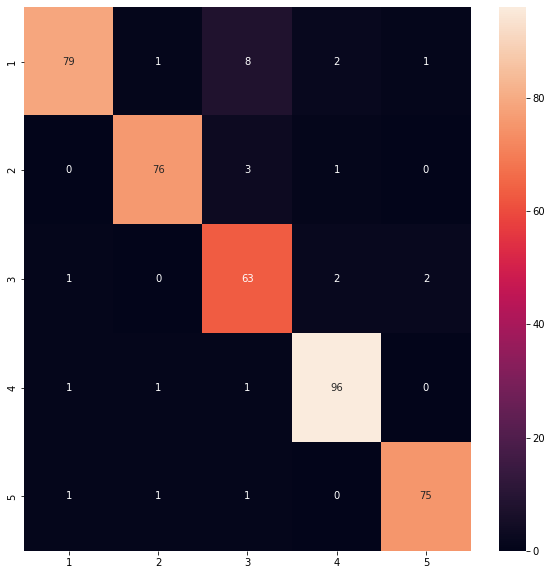

In [ ]:
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df_cm, annot=True)